In [29]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py

import astropy.units as u
from astropy.io import fits
import specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum, fit_lines
from specutils.analysis import centroid, line_flux, equivalent_width
from IPython.display import Image, display
from astroML.datasets.tools.sdss_fits import log_OIII_Hb_NII

from matplotlib.ticker import FormatStrFormatter
from matplotlib import pyplot as plt

from caterpillar import catalog

import sys
sys.path.insert(1, '/home/ksf293/anomalies-GAN-HSC/analysis')
import plotter
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import matplotlib
from matplotlib import pylab

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 100 #200
params = {'legend.fontsize': 'large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'large',
         'axes.titlesize': 'large',
         'xtick.labelsize': 'large',
         'ytick.labelsize': 'large'}
pylab.rcParams.update(params)

In [7]:
base_dir = '/scratch/ksf293/anomalies'
plot_dir = '/home/ksf293/anomalies-GAN-HSC/plots/plots_2021-04-01'
#plot_dir = '/home/ksf293/anomalies-GAN-HSC/papers/paper_main/images'

In [8]:
hdul = fits.open('../data/keck_data/bluedot/bluedot_coadd_det3.fits')

In [9]:
info = hdul.info()
hdr = hdul[0].header
data = hdul[1].data
w = data['wave']
f = data['flux']

Filename: ../data/keck_data/bluedot/bluedot_coadd_det3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      31   ()      
  1                1 BinTableHDU     30   4092R x 4C   [1D, 1D, 1D, 1K]   


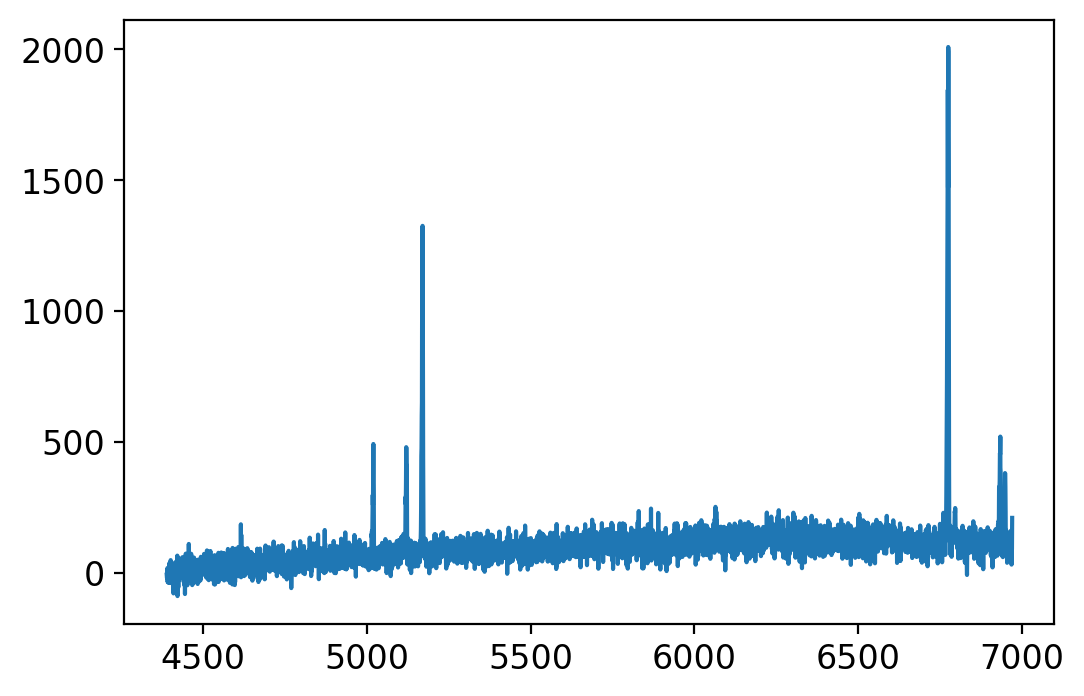

In [11]:
plt.plot(w, f)

In [15]:
#from here http://classic.sdss.org/dr6/algorithms/linestable.html
line_dict = {r'H$\alpha$':6564.61, r'H$\beta$':4862.68, 'OIIIa':4364.436, 'OIIIb':4932.603, 'OIIIc':4960.295, 
             'OIIId':5008.240, 'NIIa':6549.86, 'NIIb':6585.27, 'SIIa':6718.29, 'SIIb':6732.67}

In [16]:
# Redshift via fits by X Prochaska
# (https://docs.google.com/document/d/10n5E8VDJrd3xSTXbU-RvsNgrjl6vjcoLdYiE35Fg0tw/edit)
z=0.03221 
wave = w*u.AA / (1+z)
flux = f*10**-17 * u.Unit('erg cm-2 s-1 AA-1') #??
spec_norm = Spectrum1D(spectral_axis=wave, flux=flux, redshift=z) 
spec_norm_cont = spec_norm / fit_generic_continuum(spec_norm)(spec_norm.spectral_axis) - spec_norm/spec_norm

(-5.0, 20.0)

<Figure size 600x400 with 0 Axes>

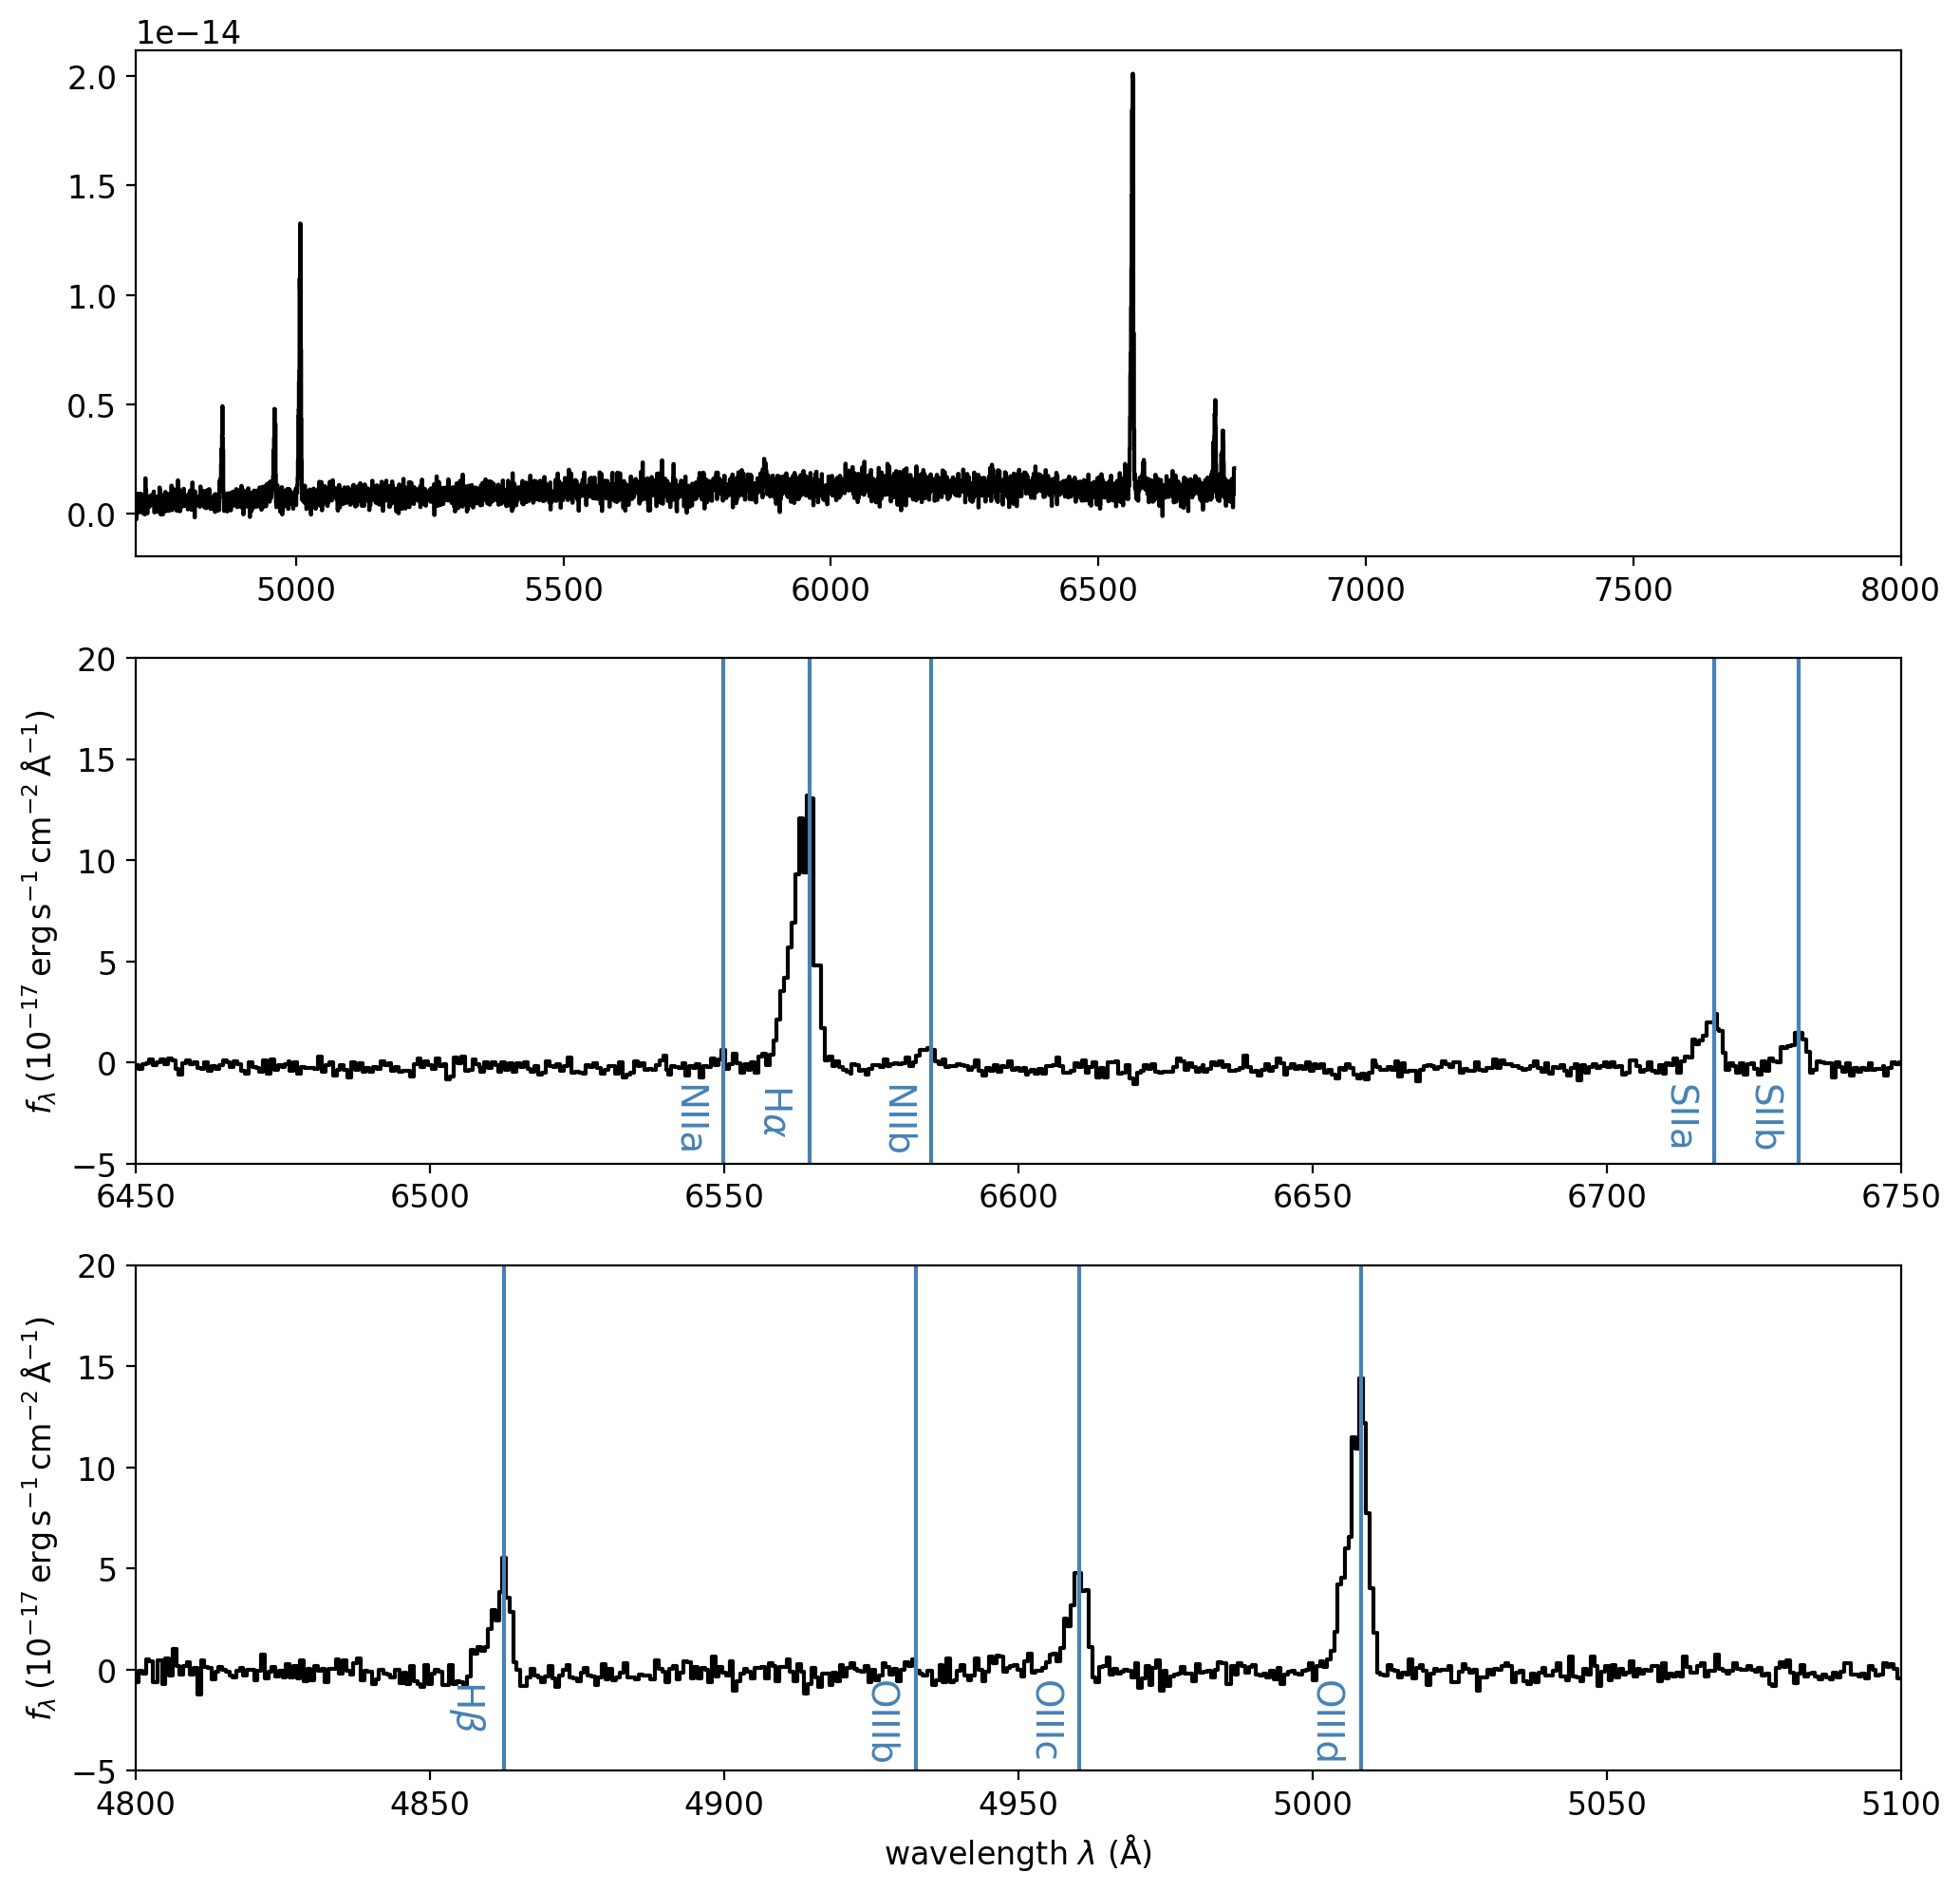

In [18]:
plt.figure()
fig, axarr = plt.subplots(3, 1, figsize=(12,12))
ax0, ax1, ax2 = axarr

# Full spectrum
ax0.step(spec_norm.wavelength, spec_norm.flux, color='black') 
ax0.set_xlim(4700, 8000)

# Halpha region
ax1.step(spec_norm_cont.wavelength, spec_norm_cont.flux, color='black') 
xmin, xmax = 6450,6750
for line in line_dict:
    wline = line_dict[line]
    if xmin<wline<xmax:
        ax1.axvline(wline, color='steelblue')
        ax1.text(wline-3, -1, line, {'color': 'steelblue', 'fontsize': 14},
             horizontalalignment='right',
             verticalalignment='top',
             rotation=270)
ax1.set_xlim(xmin, xmax)

# Hbeta region
ax2.step(spec_norm_cont.wavelength, spec_norm_cont.flux, color='black') 
#w_corrections = {r'H$\beta$':11, 'OIIIb':9, 'OIIIc':8, 
#             'OIIId':7}
xmin, xmax = 4800,5100
for line in w_corrections:
    wline = line_dict[line]# + w_corrections[line]
    if xmin<wline<xmax:
        ax2.axvline(wline, color='steelblue')
        ax2.text(wline-3, -0.5, line, {'color': 'steelblue', 'fontsize': 14},
             horizontalalignment='right',
             verticalalignment='top',
             rotation=270)
ax2.set_xlim(xmin, xmax)

# all labels and ylimits
xlabel = r'wavelength $\lambda$ ($\mathrm{\AA}$)'
ax2.set_xlabel(xlabel)
ylabel = r'$f_\lambda \: (10^{-17} \, \mathrm{erg} \, \mathrm{s}^{-1} \, \mathrm{cm}^{-2} \, \mathrm{\AA}^{-1})$'
#ax0.set_ylabel(ylabel)
ax1.set_ylabel(ylabel)
ax2.set_ylabel(ylabel)

ymin, ymax = -5, 20
#ax0.set_ylim(ymin, ymax)
ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)

# BPT

In [19]:
hdul_sdss = fits.open('../data/keck_data/SDSS_BPT_sample.fits')

In [26]:
info = hdul_sdss.info()
hdr_sdss = hdul_sdss[0].header
data_sdss = hdul_sdss[1].data
print(info)
print(hdr_sdss)
print(data_sdss.columns)

Filename: ../data/keck_data/SDSS_BPT_sample.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (140275,)   uint8   
  1  Joined        1 BinTableHDU     54   35995R x 18C   ['K', 'D', 'D', 'E', 'D', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
None
SIMPLE  =                    T / Standard FITS format                           BITPIX  =                    8 / Character data                                 NAXIS   =                    1 / Text string                                    NAXIS1  =               140275 / Number of characters                           VOTMETA =                    T / Table metadata in VOTable format               EXTEND  =                    T / There are standard extensions                  COMMENT                                                                         COMMENT The data in this primary HDU consists of bytes which                    COMMENT comprise a VOTABLE doc

In [32]:
log_nII_ha_sdss = np.log10(data_sdss['NII_6584_FLUX']/data_sdss['H_ALPHA_FLUX'])
log_oIII_hb_sdss = np.log10(data_sdss['OIII_5007_FLUX']/data_sdss['H_BETA_FLUX'])

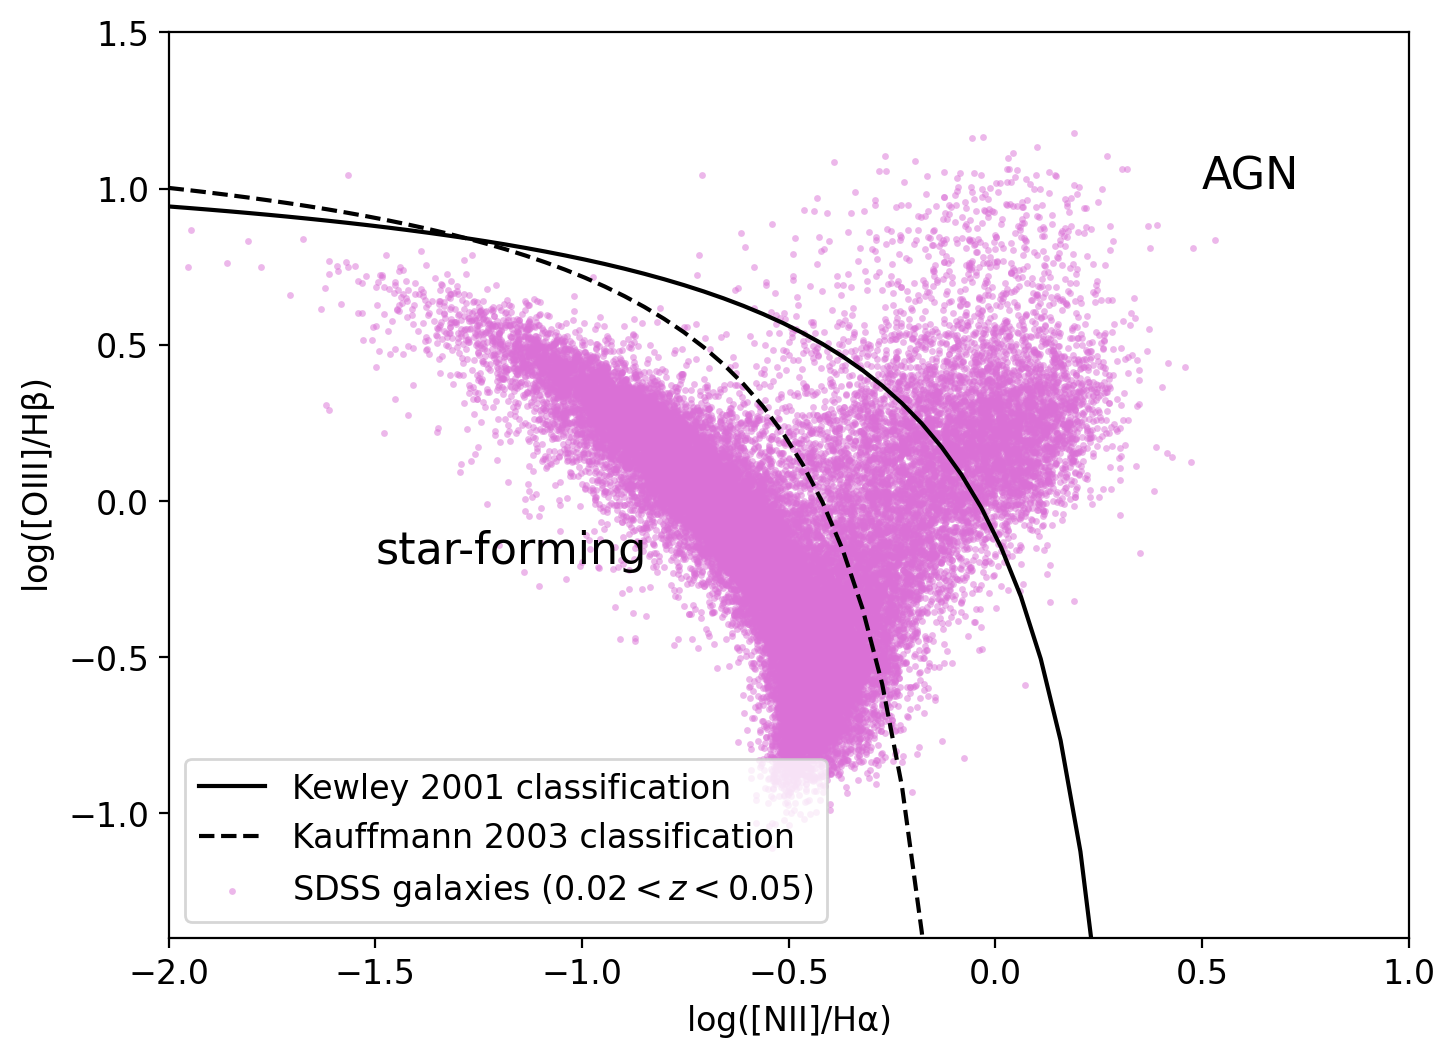

In [40]:
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize=(8,6))

# gaussian fluxes 
# fratio1 = np.log10(gflux_nII/gflux_halpha)
# fratio2 = np.log10(gflux_oIII/gflux_hbeta)

# plt.plot(fratio1, fratio2, marker='*', 
#          color='cyan', markeredgecolor='black', markersize=20, ls='None', label='HSC 43158859342174406')

plt.scatter(log_nII_ha_sdss, log_oIII_hb_sdss,
             c='orchid', alpha=0.5, s=6, lw=0, label=r'SDSS galaxies ($0.02<z<0.05$)')

NII = np.linspace(-2.0, 0.35)
plt.plot(NII, log_OIII_Hb_NII(NII), '-k', label='Kewley 2001 classification')
#plt.plot(NII, log_OIII_Hb_NII(NII, 0.1), '--k')
#plt.plot(NII, log_OIII_Hb_NII(NII, -0.1), '--k')

ka03 = 0.61/(NII-0.05) + 1.3
idx = [i for i in range(len(NII)) if NII[i]<0 ]
plt.plot(NII[idx], ka03[idx], '--k', label='Kauffmann 2003 classification')

plt.xlim(-2.0, 1.0) 
plt.ylim(-1.4, 1.5)
plt.legend(loc='lower left', **{'fontsize': 12})

plt.xlabel(r'$\mathrm{log([NII]/H\alpha)}$', fontsize='large')
plt.ylabel(r'$\mathrm{log([OIII]/H\beta)}$', fontsize='large')
plt.text(0.5, 1, "AGN", fontsize=16)
plt.text(-1.5, -0.2, "star-forming", fontsize=16)

plt.savefig(f'{plot_dir}/bpt.png', bbox_inches='tight')

## Color-color diagram

In [41]:
gr_color_sdss = data_sdss['M_g_MODEL'] - data_sdss['M_r_MODEL']
ri_color_sdss = data_sdss['M_r_MODEL'] - data_sdss['M_i_MODEL']

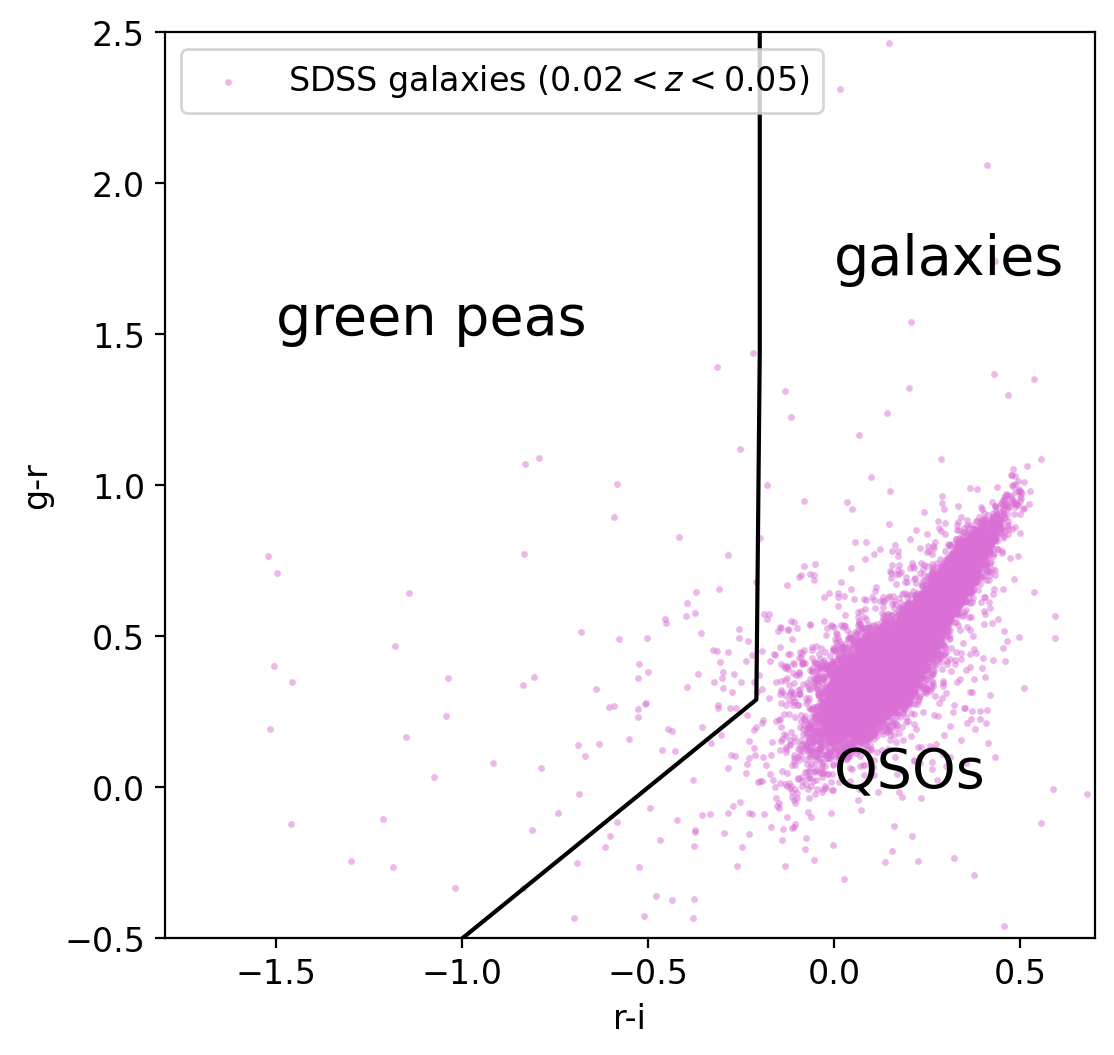

In [44]:
plt.figure(figsize=(6,6))
# plt.plot(rmag-imag, gmag-rmag, marker='*', markeredgecolor='black', color='cyan', markersize=20, 
#          label='HSC 43158859342174406', ls='None')

plt.scatter(ri_color_sdss, gr_color_sdss,
           c='orchid', alpha=0.5, s=6, lw=0, label=r'SDSS galaxies ($0.02<z<0.05$)')

rimin, rimax = -1.8, 0.7
grmin, grmax = -0.5, 2.5 
plt.xlim(rimin, rimax)
plt.ylim(grmin, grmax)


gr = np.linspace(grmin, grmax, 100)
ri = np.linspace(rimin, rimax, 100)

ricut = []
grcut = []
for i in range(len(ri)):
    grval = ri[i]+0.5
    if grval<=0.3:
        ricut.append(ri[i])
        grcut.append(grval)
    else:
        ricut.append(-0.2)
        grcut.append(gr[i])
plt.plot(ricut, grcut, color='k')

plt.text(-1.5, 1.5, 'green peas', fontsize=20)
plt.text(0, 1.7, 'galaxies', fontsize=20)
plt.text(0, 0, 'QSOs', fontsize=20)

plt.xlabel("r-i")
plt.ylabel("g-r")
plt.legend(loc='upper left')

plt.savefig(f'{plot_dir}/color-color.png', bbox_inches='tight')

## Metallicity measurments

_via yifei_ 

O3N2 = np.log10(OIII5007/Hbeta*Ha/NII6584)

metallicty_O3N2 = 8.505 - 0.221 * O3N2

N2 = np.log10(NII6584/Ha)

metallicty_N2 = 8.667 + 0.455 * N2

N2S2 = np.log10(NII6584/(SII6717+SII6731))

metallicty_N2S2 = 8.77 + N2S2 + 0.264 * N2
